# Sistema de recomendacion de Anime

### Integrantes : 
-  Verónica Martinez
- Alejandra Aravena
- Hugo Zuñiga
- Cesar Flores

In [2]:
#importar librerias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from numpy import random

In [3]:
# Cargamos la base de datos y realizamos algunas exploraciones

In [4]:
df_anime = pd.read_csv("Anime.csv", sep=';', decimal=',')
df_ratings = pd.read_csv("rating.csv")

In [5]:
df_anime.shape
#veamos numeros de filas y columnas 

(12294, 7)

In [6]:
df_ratings.shape
#veamos numeros de filas y columnas 

(7813737, 3)

In [7]:
df_ratings.info()
# informacion de las variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


In [8]:
df_ratings.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

In [9]:
#Segun info otorgada el -1 corresponde a anime que no tiene valoracion por parte del usuario

In [10]:
df_anime.info()
#Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12247 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


In [11]:
n_users = df_ratings.user_id.unique().shape[0]
n_users
# cantidad de usuarios

73515

In [12]:
n__users = df_ratings.user_id.unique().shape[0] #cantidad usuarios
n__items = df_ratings.anime_id.unique().shape[0]# cantidad anime
print (str(n__users) + ' users')
print (str(n__items) + ' items')

73515 users
11200 items


In [13]:
#Empezamos con la modelacion
##buscamos valores nulos en las columnas genero, tipo y ratings

In [14]:
df_anime[df_anime['genre'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id             name genre   type episodes  rating  members
8304      29655       Chanda Gou   NaN  Movie        1    4.42       91
9265      29920  Kobutori (1957)   NaN  Movie        1    4.75       90
7349      19219      Modern No.2   NaN  Movie        1    5.52      374
10863     30309   Yuuyake Dandan   NaN  Movie        6    5.55      542
7982      29957       Count Down   NaN  Movie        1    4.27      231

In [15]:
df_anime[df_anime['type'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                              name  \
11070     32032                   Seikaisuru Kado   
11058     24023                        Project758   
10963     31456  Code:Realize: Sousei no Himegimi   
10983     34332                     Flying Babies   
10995     28613            Ginga Jinpuu Jinraiger   

                                     genre type episodes  rating  members  
11070                        Drama, Sci-Fi  NaN  Unknown     NaN     1797  
11058                                Drama  NaN  Unknown     NaN      455  
10963  Adventure, Fantasy, Romance, Shoujo  NaN  Unknown     NaN     4017  
10983                 Drama, Slice of Life  NaN  Unknown     NaN       22  
10995             Action, Adventure, Mecha  NaN  Unknown     NaN      627

In [16]:
df_anime[df_anime['rating'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                                            name  \
11070     32032                                 Seikaisuru Kado   
11058     24023                                      Project758   
11018     33089                                  Kemono Friends   
10942     33564                             Armed Blue: Gunvolt   
10969     34430  Detective Conan Movie 21: Deep Red Love Letter   

                                                   genre   type episodes  \
11070                                      Drama, Sci-Fi    NaN  Unknown   
11058                                              Drama    NaN  Unknown   
11018                                  Adventure, Comedy     TV  Unknown   
10942                        Action, Sci-Fi, Super Power    OVA  Unknown   
10969  Action, Drama, Historical, Mystery, Police, Ro...  Movie        1   

       rating  members  
11070     NaN     1797  
11058     NaN      455  
11018     NaN      572  
10942     NaN     2549  
10969     NaN     1997

- Valores vacios en Genero : No podemos rellenar pues no sabemos la data
- Valores vacios en Tipo:  No podemos rellenar pues no sabemos la data
- Valores vacios en Ranking : Serán rellenados (con media o promedio u otro)

In [17]:
df_anime = df_anime.replace('Unknown', np.nan) # reemplazo desconocido por nan 
df_anime = df_anime.dropna(how = 'all') # eliminamos datos nan
df_anime['episodes'] = df_anime['episodes'].map(lambda x:np.nan if pd.isnull(x) else int(x))
df_ratings = df_ratings.replace(-1, np.nan)

In [18]:
#Evaluemos distribucion

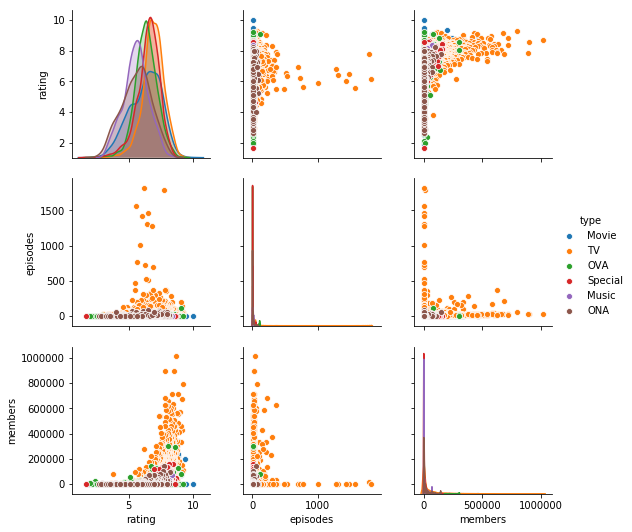

In [19]:
sns.pairplot(data=df_anime[['type','rating','episodes','members']].dropna(),hue='type')

- La distribución de los ratings es __Leptocúrtica__ ---->  es decir existe una gran concentración de los valores en torno a su media, con mayor presencia entre los ranking 5 y 8 (y algunos ouliers)
- En base a ello llenaremos los valores faltantes usando la MEDIANA de los rating 

(array([2.300e+02, 2.000e+00, 2.200e+01, 2.110e+02, 7.520e+02, 2.372e+03,
        4.784e+03, 3.294e+03, 6.030e+02, 2.400e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

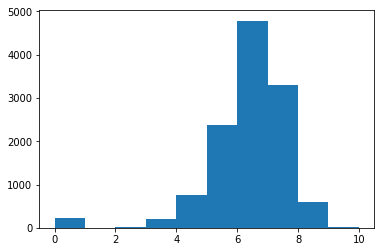

In [20]:
plt.hist(df_anime['rating'].fillna(0))

In [21]:
# rellenamos nan con la media 
df_anime['rating'] =df_anime['rating'].fillna(df_anime.rating.median())

(array([   6.,   49.,  275.,  733., 1824., 3884., 3822., 1467.,  225.,
           9.]),
 array([ 1.67 ,  2.503,  3.336,  4.169,  5.002,  5.835,  6.668,  7.501,
         8.334,  9.167, 10.   ]),
 <a list of 10 Patch objects>)

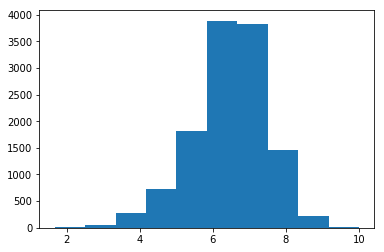

In [22]:
plt.hist(df_anime['rating'].fillna(0))

In [23]:
# es posible ver el cambio en la distribucion

In [24]:
# Veamos especificamente cuantas valoraciones existen

pd.DataFrame(df_ratings.groupby('rating').user_id.count()).reset_index()

rating  user_id
0     1.0    16649
1     2.0    23150
2     3.0    41453
3     4.0   104291
4     5.0   282806
5     6.0   637775
6     7.0  1375287
7     8.0  1646019
8     9.0  1254096
9    10.0   955715

In [25]:
df_ratings.count() #hay datos perdidos en rating 

user_id     7813737
anime_id    7813737
rating      6337241
dtype: int64

In [26]:
# selección de animes que tengan cantidad de rating superior a 80 para hacer mas rapida la consulta
# para ello explorar distribucion x tipo

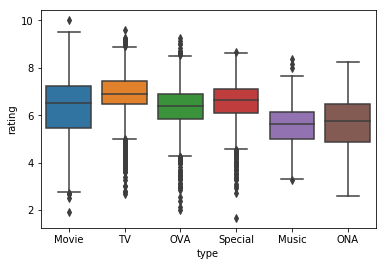

In [27]:
sns.boxplot(data = df_anime, y = 'rating', x='type')

__Priorizamos catogorizar por genero. Tambien cuantos usser han visto cada anime__

(array([1.0675e+04, 3.4500e+02, 1.0000e+02, 4.5000e+01, 1.7000e+01,
        7.0000e+00, 7.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 3.93490e+03, 7.86880e+03, 1.18027e+04, 1.57366e+04,
        1.96705e+04, 2.36044e+04, 2.75383e+04, 3.14722e+04, 3.54061e+04,
        3.93400e+04]),
 <a list of 10 Patch objects>)

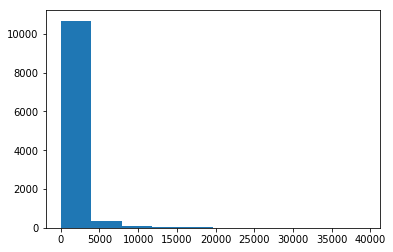

In [28]:
plt.hist(df_ratings.groupby(['anime_id'])['anime_id'].count())

Existe un sesgo, pues recomendara las series mas vistas sobre las menos vistas (Ver grafico)

La informacion del dataset establese que las serie  series sin rating no han sido evaluadas ya que no se encuentran aun en emision o no han sido lanzadas, por lo que trataremos que nuestro sistema tambien sea capaz de recomendarlas.

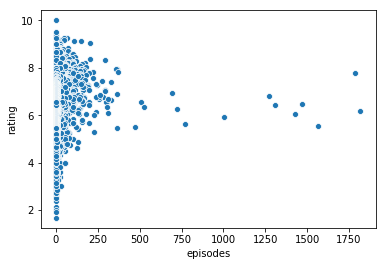

In [29]:
sns.scatterplot( x = df_anime['episodes'], y= df_anime['rating'])

Se prefiere anime con menor cantidad de episodios

## Representaciones Matriciales

* Unimos los datasets para extraer subsets de entrenamiento!

In [30]:
fulldf = pd.merge(df_anime, df_ratings, how = 'right', on ='anime_id', suffixes = ['_avg', '_user'])
fulldf.rename(columns = {'rating_user':'user_rating', 'rating_avg':'avg_rating'}, inplace = True)

In [31]:
fulldf.sample(10)

anime_id                                               name  \
1555895     25013                                   Akatsuki no Yona   
4712935     11179                       Papa no Iukoto wo Kikinasai!   
5060970       191            Love Hina Christmas Special: Silent Eve   
587807      16498                                 Shingeki no Kyojin   
6865708      5526                    Pokemon: Pikachu no Natsuyasumi   
2383948      6351  Clannad: After Story - Mou Hitotsu no Sekai, K...   
1347974      1519                   Black Lagoon: The Second Barrage   
5009615      5150                                   Hatsukoi Limited   
7554790      2476                                        School Days   
7099610      6205                                            Kämpfer   

                                                     genre     type  episodes  \
1555895  Action, Adventure, Comedy, Fantasy, Romance, S...       TV      24.0   
4712935                     Comedy, Romance, Slice of Life       TV      12.0   
5060970                     Comedy, Romance, Slice of Life  Special       1.0   
587807        Action, Drama, Fantasy, Shounen, Super Power       TV      25.0   
6865708                              Comedy, Fantasy, Kids    Movie       1.0   
2383948                             Drama, Romance, School  Special       1.0   
1347974                                     Action, Seinen       TV      12.0   
5009615                   Comedy, Romance, School, Shounen       TV      12.0   
7554790                      Drama, Harem, Romance, School       TV      12.0   
7099610  Action, Comedy, Ecchi, Romance, School, Shoujo...       TV      12.0   

         avg_rating   members  user_id  user_rating  
1555895        8.23  216674.0    72071          8.0  
4712935        7.51   97674.0    55135          7.0  
5060970        7.44   45137.0    60657          NaN  
587807         8.54  896229.0    43656          8.0  
6865708        6.86   19960.0    42368          7.0  
2383948        8.02  138364.0     1143          NaN  
1347974        8.30  203233.0    52919          8.0  
5009615        7.45   54796.0    40360          7.0  
7554790        6.17  279183.0    22541          6.0  
7099610        6.73  146631.0    68104          NaN

In [32]:
df_genres_list = df_anime['genre'].str.get_dummies(sep = ', ')

## Para el filtro de Contenido

In [33]:
df_genres_list.sample(10)

Action  Adventure  Cars  Comedy  Dark Fantasy  Dementia  Demons  Drama  \
2749        0          0     0       0             0         0       0      1   
11476       0          0     0       0             0         0       0      0   
11372       0          0     0       0             0         0       0      0   
5645        1          1     0       0             0         0       0      0   
6390        0          0     0       0             0         0       0      0   
1511        0          1     0       1             0         0       0      1   
712         0          1     0       1             0         0       1      0   
11865       0          0     0       0             0         0       0      0   
7108        0          0     0       0             0         0       0      0   
7104        0          0     0       0             0         0       0      0   

       Ecchi  Fantasy  ...  Shounen Ai  Slice of Life  Space  Sports  \
2749       0        0  ...           0              0      0       0   
11476      0        0  ...           0              0      0       0   
11372      0        0  ...           0              0      0       0   
5645       0        1  ...           0              0      0       0   
6390       0        1  ...           0              0      0       0   
1511       0        1  ...           0              0      0       0   
712        0        1  ...           0              0      0       0   
11865      0        0  ...           0              0      0       0   
7108       0        0  ...           0              0      0       0   
7104       0        0  ...           0              0      0       0   

       Super Power  Supernatural  Thriller  Vampire  Yaoi  Yuri  
2749             0             0         0        0     0     0  
11476            0             0         0        0     0     0  
11372            0             0         0        0     0     0  
5645             0             0         0        0     0     0  
6390             0             0         0        0     0     0  
1511             0             0         0        0     0     0  
712              0             0         0        0     0     0  
11865            0             0         0        0     0     0  
7108             0             0         0        0     0     0  
7104             0             0         0        0     0     0  

[10 rows x 46 columns]

In [34]:
df_types_list = pd.get_dummies(df_anime[["type"]])
df_types_list.sample(10)

type_Movie  type_Music  type_ONA  type_OVA  type_Special  type_TV
6997            0           1         0         0             0        0
7558            1           0         0         0             0        0
6462            0           0         0         1             0        0
6226            0           0         0         0             0        1
4630            0           0         0         1             0        0
1258            0           0         0         1             0        0
1666            0           0         0         1             0        0
10034           1           0         0         0             0        0
6619            0           0         0         0             0        1
8025            1           0         0         0             0        0

In [35]:
#crear el dataset de entrenamiento final para contenido
df_feat = df_anime[['members','rating','episodes']]
df_features = pd.concat([df_feat,df_genres_list, df_types_list], axis = 1).fillna(0)

In [36]:
#funciones de Apoyo

In [37]:
def get_nombre_from_index(index):
    return df_anime[df_anime.index == index]['name'].values[0]
def get_id_from_nombre(name):
    return df_anime[df_anime.name == name]['anime_id'].values[0]
def get_index_from_id(anime_id):
    return df_anime[df_anime.anime_id == anime_id].index.values[0]

In [38]:
#Obtendremos el promedio de las valoraciones que el usuario ha dado a las series para determinar si le gustan
# recomendaremos series similares a sus favoritas o mejor valoradas.
## Consideraremos el valor promedio de las series que el usuario haya evaluado
def get_user_top_list(user):
    df_user = df_ratings[df_ratings['user_id']==user]
    df_rated = df_user.dropna(how = 'any')
    avg =  df_rated.rating.mean() 
    df_toplist = df_rated[df_rated['rating']>= avg].sort_values('rating', ascending = False).head(10)
    return list(df_toplist['anime_id'])
def get_user_viewed_list(user):
    return list(df_ratings[df_ratings['user_id']==user]['anime_id'])

## Modelado por KNN (Contenido)

* Se usa k = K+1 siendo K el numero de recomendaciones que se desea obtener, ya que la primera siempre es el mismo dato
* Como tenemos variables dummy binarias vs variables con valor muy alto (episodios, miembros) se utilizara  la biblioteca MaxAbsScaler para convertir dichos valores en una distribucion 0-1. Equivale a normalizar con funcion Z

In [39]:
mas = MaxAbsScaler()
df_features2 = mas.fit_transform(df_features)

In [40]:
k = 10

In [41]:
neighbors_content = NearestNeighbors(n_neighbors = k, algorithm = 'ball_tree')

In [42]:
neighbors_content.fit(df_features2)
# entrenamos 

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [43]:
distances, indices = neighbors_content.kneighbors(df_features2)

In [44]:
distances.shape

(12294, 10)

In [45]:
indices.shape

(12294, 10)

In [128]:
def get_recommendations(aid):
    anime =  get_index_from_id(aid)
    test = list(indices[anime,1:11])
    nb = []
    for i in test:
        a_name = get_nombre_from_index(i)
        nb.append(a_name)
    return nb

### Ver comparacion entre la recomendacion y la serie

* Extraer las series que el usuario ya haya visto

In [129]:
get_user_top_list(73509)

[199]

In [130]:
get_recommendations(23283)

['Re:Zero kara Hajimeru Isekai Seikatsu',
 'Mahou Shoujo Madoka★Magica',
 'Higurashi no Naku Koro ni Kai',
 'Gyakkyou Burai Kaiji: Ultimate Survivor',
 'Selector Infected WIXOSS',
 'Gyakkyou Burai Kaiji: Hakairoku-hen',
 'Touhai Densetsu Akagi: Yami ni Maiorita Tensai',
 'Selector Spread WIXOSS',
 'Steins;Gate']

* Recomendar series hasta que encontremos n series que el usuario no ha visto

In [131]:
def get_n_recommends(user, n):
    vistas = list(get_user_viewed_list(user))
    liked = list(get_user_top_list(user))
    lista = []
    for i in liked:
        ani = pd.Series(get_recommendations(i))
        recs = np.setdiff1d(ani, vistas) 
        lista.extend(recs)
        if(len(lista) > n):
            lista = lista[n:]
            break
    return lista

* probar para un usuario cualquiera de acuerdo a la lista anterior

In [132]:
get_n_recommends(3,5)

['Saint Luminous Jogakuin',
 'Shinreigari: Ghost Hound',
 'UN-GO',
 'Umineko no Naku Koro ni']

In [133]:
get_n_recommends(73509, 10)

['Bakemono no Ko',
 'Da Yu Hai Tang',
 'Jungle Taitei Leo: Hon-o-ji',
 'Mai Mai Shinko to Sennen no Mahou',
 'Marco: Haha wo Tazunete Sanzenri',
 'Momo e no Tegami',
 'Oseam',
 'Shisha no Sho',
 'Tobe! Kujira no Peek']

In [134]:
get_n_recommends(2, 10)

['Area no Kishi',
 'Diamond no Ace',
 'Diamond no Ace: Second Season',
 'Haikyuu!!',
 'Kuroko no Basket 2nd Season',
 'Kuroko no Basket 3rd Season',
 'Teekyuu',
 'Teekyuu 2',
 'Teekyuu 3']

In [47]:
get_n_recommends(5, 10)

NameError: name 'get_n_recommends' is not defined